# Forecasting model - DL Approach using LSTM

#### Importing Libraries

In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scalecast.Forecaster import Forecaster

#### Reading data

In [112]:
df_06 = pd.read_csv('data/radar_count_2022_01_06.csv', index_col=0)
df_07 = pd.read_csv('data/radar_count_2022_07_12.csv', index_col=0)
df_05_23 = pd.read_csv('data/radar_count_2023_01_05.csv', index_col=0)
df = pd.concat([df_06, df_07, df_05_23], axis=0)
df

entity_id  faixa  \
time_index                                                          
2022-03-29 00:00:00+00  urn:ngsi-ld:Count:aveiro_radar:p33      1   
2022-03-29 00:00:01+00  urn:ngsi-ld:Count:aveiro_radar:p33      2   
2022-03-29 00:00:00+00   urn:ngsi-ld:Count:aveiro_radar:p1      1   
2022-03-29 00:00:00+00  urn:ngsi-ld:Count:aveiro_radar:p35      1   
2022-03-29 00:00:01+00  urn:ngsi-ld:Count:aveiro_radar:p35      2   
...                                                    ...    ...   
2023-04-22 23:59:01+00   urn:ngsi-ld:Count:aveiro_radar:p3      2   
2023-04-22 23:59:00+00  urn:ngsi-ld:Count:aveiro_radar:p33      1   
2023-04-22 23:59:01+00  urn:ngsi-ld:Count:aveiro_radar:p33      2   
2023-04-22 23:59:00+00  urn:ngsi-ld:Count:aveiro_radar:p35      1   
2023-04-22 23:59:01+00  urn:ngsi-ld:Count:aveiro_radar:p35      2   

                        vehiclelight  speedlight  vehicleheavy  speedheavy  \
time_index                                                                   
2022-03-29 00:00:00+00             0    0.000000             0    0.000000   
2022-03-29 00:00:01+00             0    0.000000             0    0.000000   
2022-03-29 00:00:00+00             1   10.664516             0    0.000000   
2022-03-29 00:00:00+00             3   14.599231             1    9.177778   
2022-03-29 00:00:01+00             1   11.525619             0    0.000000   
...                              ...         ...           ...         ...   
2023-04-22 23:59:01+00             5    5.408921             0    0.000000   
2023-04-22 23:59:00+00             3    7.503738             0    0.000000   
2023-04-22 23:59:01+00             2    7.378305             0    0.000000   
2023-04-22 23:59:00+00             5   12.284866             0    0.000000   
2023-04-22 23:59:01+00             3   11.366398             0    0.000000   

                        vehicleothers  speedothers  accelerationlight  \
time_index                                                              
2022-03-29 00:00:00+00              2     3.407759           0.000000   
2022-03-29 00:00:01+00              1     1.460000           0.000000   
2022-03-29 00:00:00+00              0     0.000000           0.000335   
2022-03-29 00:00:00+00              0     0.000000           0.000445   
2022-03-29 00:00:01+00              0     0.000000          -0.001053   
...                               ...          ...                ...   
2023-04-22 23:59:01+00              0     0.000000           0.011225   
2023-04-22 23:59:00+00              0     0.000000          -0.101652   
2023-04-22 23:59:01+00              1     0.984906          -0.128507   
2023-04-22 23:59:00+00              0     0.000000           0.140379   
2023-04-22 23:59:01+00              1    14.798592          -0.182493   

                        accelerationheavy  accelerationothers  
time_index                                                     
2022-03-29 00:00:00+00             0.0000            0.000175  
2022-03-29 00:00:01+00             0.0000            0.000271  
2022-03-29 00:00:00+00             0.0000            0.000000  
2022-03-29 00:00:00+00             0.0005            0.000000  
2022-03-29 00:00:01+00             0.0000            0.000000  
...                                   ...                 ...  
2023-04-22 23:59:01+00             0.0000            0.000000  
2023-04-22 23:59:00+00             0.0000            0.000000  
2023-04-22 23:59:01+00             0.0000           -0.006410  
2023-04-22 23:59:00+00             0.0000            0.000000  
2023-04-22 23:59:01+00             0.0000           -0.209184  

[3682217 rows x 11 columns]

#### Dropping the columns which are not required 
##### Faixa, speeds, acceleration

In [113]:
# now we can drop the columns we don't need
df.drop(['faixa', 'speedlight', 'speedheavy', 'speedothers', 'accelerationlight', 'accelerationheavy', 'accelerationothers'], axis=1, inplace=True)

#### Now lets take only the values from radar 35 (ISCA)

In [114]:
df = df[df['entity_id'] == 'urn:ngsi-ld:Count:aveiro_radar:p35']

In [115]:
df = df.sort_values(by=['time_index'])
df.isnull().sum()   # no missing values
df

entity_id  vehiclelight  \
time_index                                                                 
2022-01-11 17:22:00+00  urn:ngsi-ld:Count:aveiro_radar:p35            20   
2022-01-11 17:22:01+00  urn:ngsi-ld:Count:aveiro_radar:p35            13   
2022-01-11 17:23:00+00  urn:ngsi-ld:Count:aveiro_radar:p35             9   
2022-01-11 17:23:01+00  urn:ngsi-ld:Count:aveiro_radar:p35             6   
2022-01-11 17:24:00+00  urn:ngsi-ld:Count:aveiro_radar:p35            12   
...                                                    ...           ...   
2023-05-25 15:28:01+00  urn:ngsi-ld:Count:aveiro_radar:p35             8   
2023-05-25 15:29:00+00  urn:ngsi-ld:Count:aveiro_radar:p35            10   
2023-05-25 15:29:01+00  urn:ngsi-ld:Count:aveiro_radar:p35            14   
2023-05-25 15:30:00+00  urn:ngsi-ld:Count:aveiro_radar:p35            10   
2023-05-25 15:30:01+00  urn:ngsi-ld:Count:aveiro_radar:p35            11   

                        vehicleheavy  vehicleothers  
time_index                                           
2022-01-11 17:22:00+00             0              0  
2022-01-11 17:22:01+00             0              3  
2022-01-11 17:23:00+00             0              1  
2022-01-11 17:23:01+00             0              4  
2022-01-11 17:24:00+00             2              2  
...                              ...            ...  
2023-05-25 15:28:01+00             1              6  
2023-05-25 15:29:00+00             2              3  
2023-05-25 15:29:01+00             2              5  
2023-05-25 15:30:00+00             1              1  
2023-05-25 15:30:01+00             0              2  

[925705 rows x 4 columns]

In [116]:
# create another column thats the sum of all vehicles
df['total'] = df['vehiclelight'] + df['vehicleheavy'] + df['vehicleothers']

In [117]:
df

entity_id  vehiclelight  \
time_index                                                                 
2022-01-11 17:22:00+00  urn:ngsi-ld:Count:aveiro_radar:p35            20   
2022-01-11 17:22:01+00  urn:ngsi-ld:Count:aveiro_radar:p35            13   
2022-01-11 17:23:00+00  urn:ngsi-ld:Count:aveiro_radar:p35             9   
2022-01-11 17:23:01+00  urn:ngsi-ld:Count:aveiro_radar:p35             6   
2022-01-11 17:24:00+00  urn:ngsi-ld:Count:aveiro_radar:p35            12   
...                                                    ...           ...   
2023-05-25 15:28:01+00  urn:ngsi-ld:Count:aveiro_radar:p35             8   
2023-05-25 15:29:00+00  urn:ngsi-ld:Count:aveiro_radar:p35            10   
2023-05-25 15:29:01+00  urn:ngsi-ld:Count:aveiro_radar:p35            14   
2023-05-25 15:30:00+00  urn:ngsi-ld:Count:aveiro_radar:p35            10   
2023-05-25 15:30:01+00  urn:ngsi-ld:Count:aveiro_radar:p35            11   

                        vehicleheavy  vehicleothers  total  
time_index                                                  
2022-01-11 17:22:00+00             0              0     20  
2022-01-11 17:22:01+00             0              3     16  
2022-01-11 17:23:00+00             0              1     10  
2022-01-11 17:23:01+00             0              4     10  
2022-01-11 17:24:00+00             2              2     16  
...                              ...            ...    ...  
2023-05-25 15:28:01+00             1              6     15  
2023-05-25 15:29:00+00             2              3     15  
2023-05-25 15:29:01+00             2              5     21  
2023-05-25 15:30:00+00             1              1     12  
2023-05-25 15:30:01+00             0              2     13  

[925705 rows x 5 columns]

##### we don't really need the entity column nor the vehicles types, only the total count of vehicles

In [118]:
df = df.drop(['entity_id'], axis=1)
df = df.drop(['vehiclelight', 'vehicleheavy', 'vehicleothers'], axis=1)

#### Now our data is:
#####
time_index, total
..., ...

#### The data is distributed in 1 minute intervals, so we need to resample it to day and hour (2022-01-11 10:00:00)

In [119]:
# agregate by day and hour
df.index = pd.to_datetime(df.index)
df = df.resample('H').sum()
# keep only the data from 2022-01-12 00:00:00 to the end

df = df[df.index >= '2022-01-12 00:00:00']
df

total
time_index                      
2022-01-12 00:00:00+00:00    161
2022-01-12 01:00:00+00:00     77
2022-01-12 02:00:00+00:00     43
2022-01-12 03:00:00+00:00     31
2022-01-12 04:00:00+00:00     23
...                          ...
2023-05-25 11:00:00+00:00   1554
2023-05-25 12:00:00+00:00   1664
2023-05-25 13:00:00+00:00   1492
2023-05-25 14:00:00+00:00   1510
2023-05-25 15:00:00+00:00    947

[11968 rows x 1 columns]

In [120]:
# keep the weekly data
# convert to weekly data
df_weekly = df.resample('W').sum()
df_weekly


total
time_index                       
2022-01-16 00:00:00+00:00   80476
2022-01-23 00:00:00+00:00   70774
2022-01-30 00:00:00+00:00  127831
2022-02-06 00:00:00+00:00  125960
2022-02-13 00:00:00+00:00  126998
...                           ...
2023-04-30 00:00:00+00:00  157198
2023-05-07 00:00:00+00:00   48150
2023-05-14 00:00:00+00:00       0
2023-05-21 00:00:00+00:00  103455
2023-05-28 00:00:00+00:00   89004

[72 rows x 1 columns]

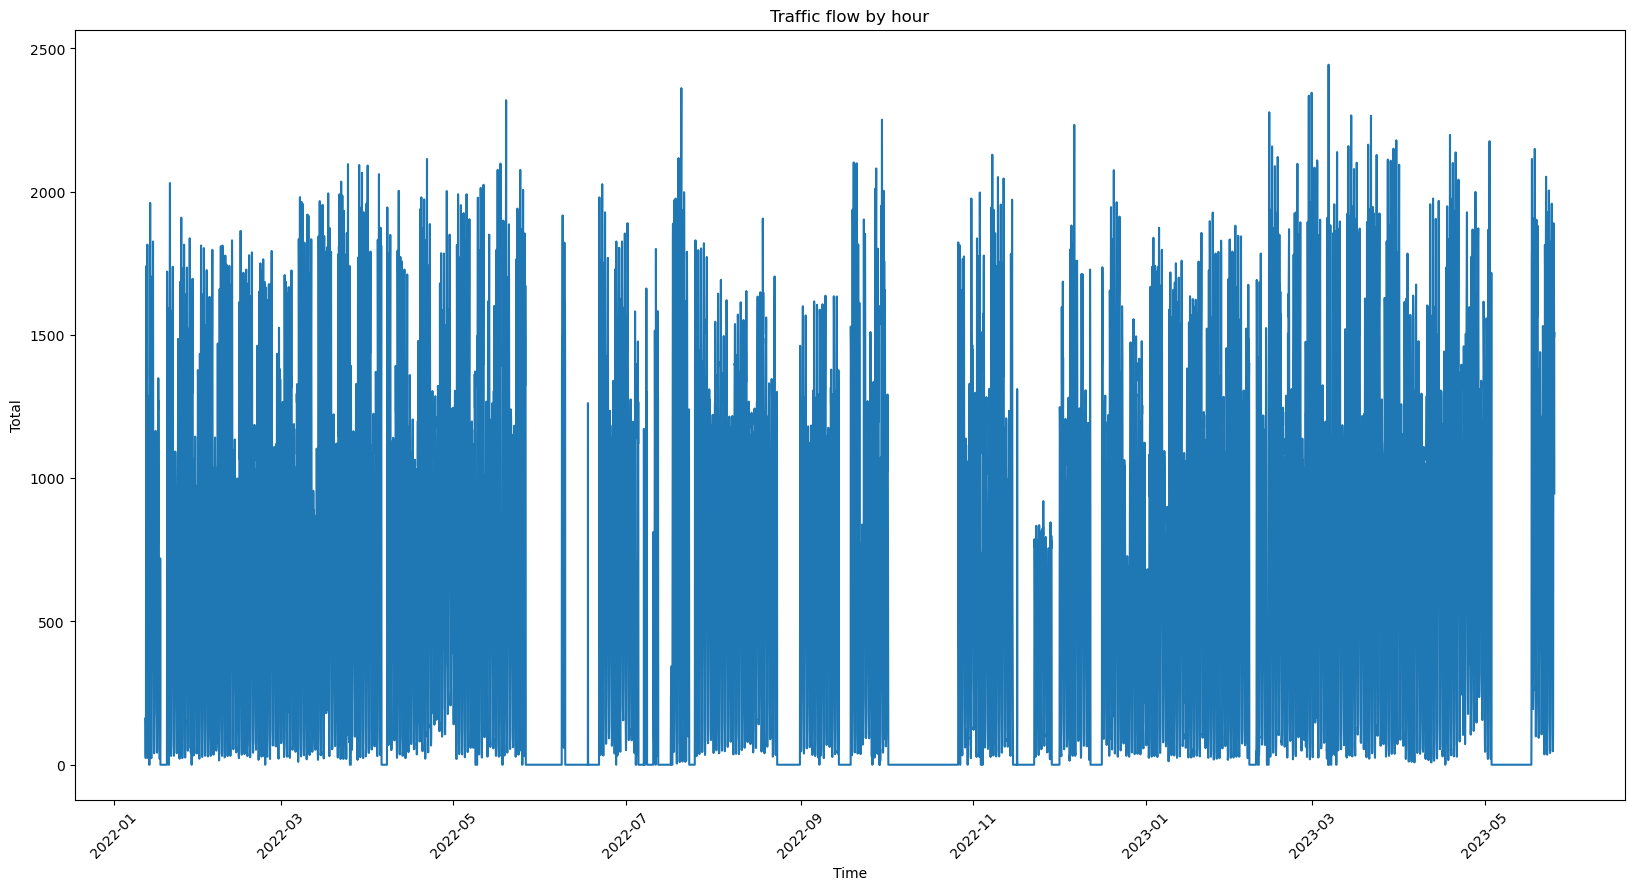

In [121]:
# lets see how the data looks like

plt.figure(figsize=(20,10))
plt.plot(df.index, df['total'])
plt.title('Traffic flow by hour')
# show the months on the x axis
plt.xticks(rotation=45)
plt.xlabel('Time')
plt.ylabel('Total')
plt.show()


#### from the plot above we can see that there are some missing values, so we need to fill them 
#### we will use the mean of the previous and next values to fill the missing ones

#### Just to have a better understanding of the data, lets plot it by month

In [122]:
df2 = df.copy()

# agregate by month
df2.index = pd.to_datetime(df2.index)
df2 = df2.resample('M').sum()
# keep only the year-month
df2.index = df2.index.strftime('%Y-%m')
df2

total
time_index        
2022-01     298987
2022-02     506736
2022-03     594854
2022-04     545537
2022-05     508433
2022-06     231422
2022-07     391821
2022-08     436313
2022-09     470485
2022-10     107962
2022-11     331262
2022-12     470616
2023-01     574097
2023-02     495951
2023-03     662898
2023-04     618232
2023-05     240609

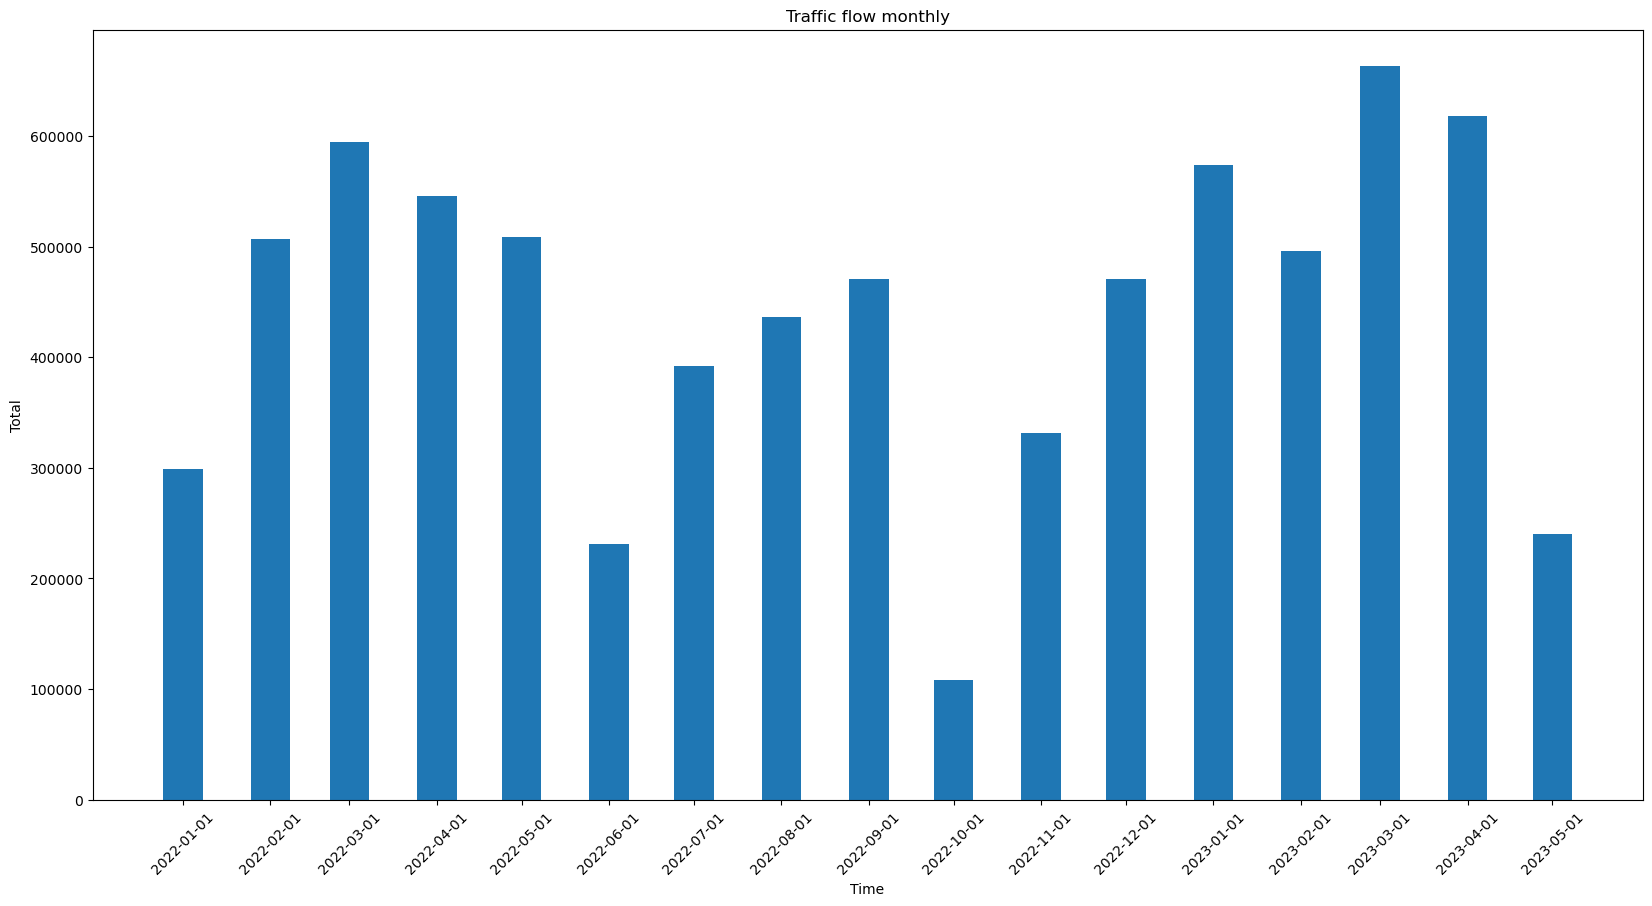

In [124]:

# convert df2.index to datetime format
df2.index = pd.to_datetime(df2.index)
# plot the data bar monthly
plt.figure(figsize=(20,10))
plt.bar(df2.index, df2['total'], width=14)
plt.title('Traffic flow monthly')
# show all ticks
plt.xticks(df2.index, rotation=45)
plt.xlabel('Time')
plt.ylabel('Total')
plt.show()



In [125]:
# agregate by day
df3 = df.copy()
df3.index = pd.to_datetime(df3.index)
df3 = df3.resample('D').sum()
df3


total
time_index                      
2022-01-12 00:00:00+00:00  18096
2022-01-13 00:00:00+00:00  13280
2022-01-14 00:00:00+00:00  21058
2022-01-15 00:00:00+00:00  14540
2022-01-16 00:00:00+00:00  13502
...                          ...
2023-05-21 00:00:00+00:00  17365
2023-05-22 00:00:00+00:00  24303
2023-05-23 00:00:00+00:00  24993
2023-05-24 00:00:00+00:00  24834
2023-05-25 00:00:00+00:00  14874

[499 rows x 1 columns]

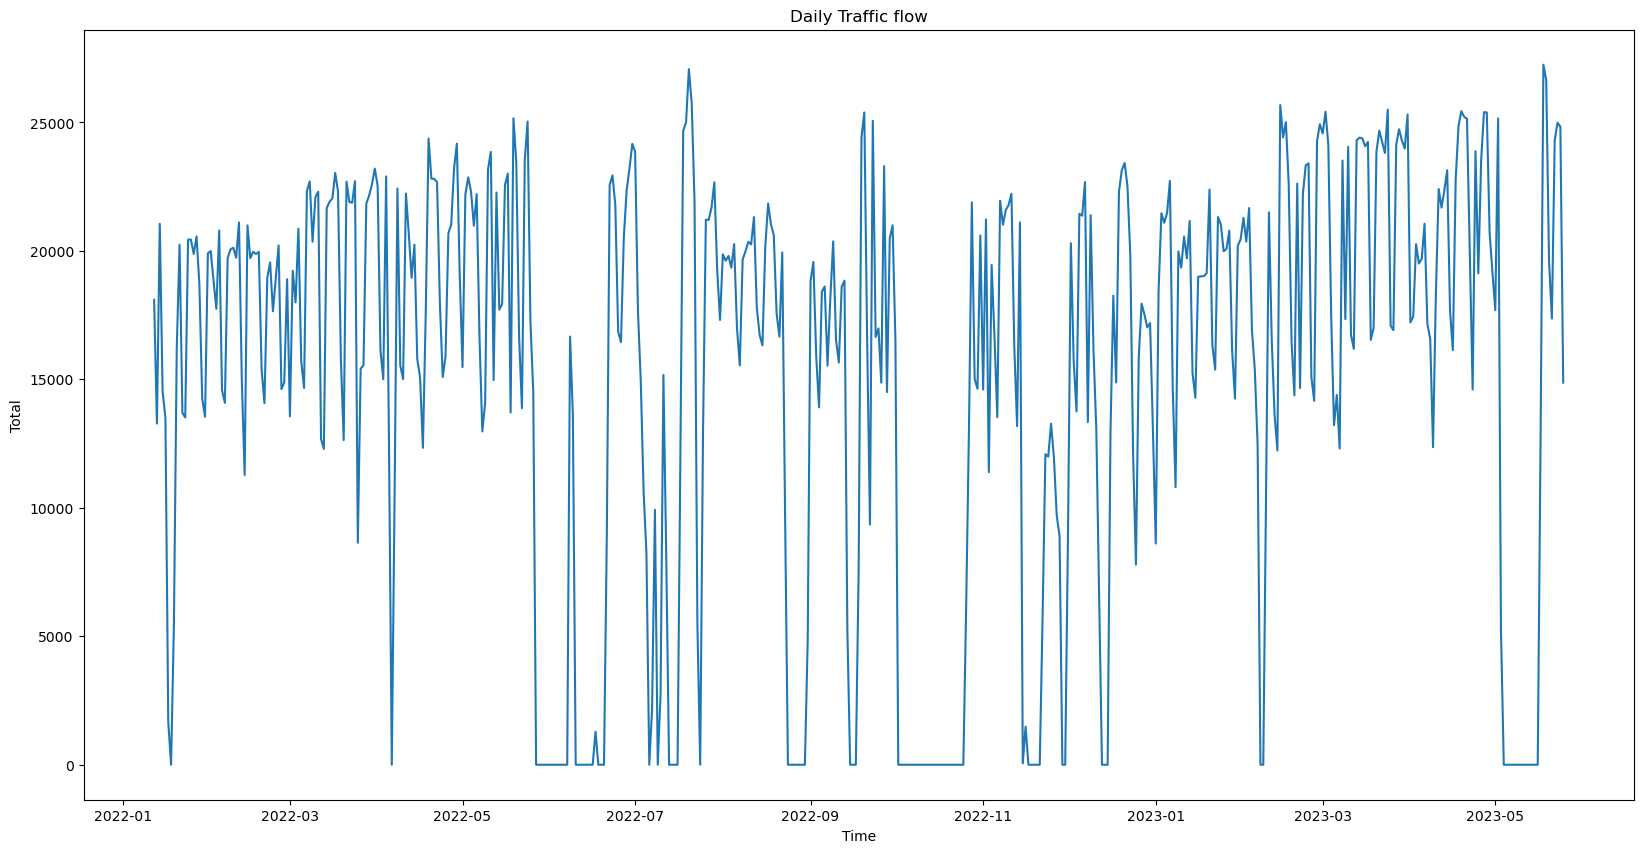

In [126]:
# plot the data
plt.figure(figsize=(20,10))
plt.plot(df3.index, df3['total'])
plt.title('Daily Traffic flow')
plt.xlabel('Time')
plt.ylabel('Total')
plt.show()


In [127]:
# get the data from 2022-03-10
df4 = df[df.index >= '2022-03-12']
df4 = df4[df4.index <= '2022-03-12 23:00:00']
df4


total
time_index                      
2022-03-12 00:00:00+00:00    276
2022-03-12 01:00:00+00:00    162
2022-03-12 02:00:00+00:00     96
2022-03-12 03:00:00+00:00     45
2022-03-12 04:00:00+00:00     55
2022-03-12 05:00:00+00:00     74
2022-03-12 06:00:00+00:00     96
2022-03-12 07:00:00+00:00    352
2022-03-12 08:00:00+00:00    513
2022-03-12 09:00:00+00:00    666
2022-03-12 10:00:00+00:00    827
2022-03-12 11:00:00+00:00    956
2022-03-12 12:00:00+00:00    948
2022-03-12 13:00:00+00:00    806
2022-03-12 14:00:00+00:00    813
2022-03-12 15:00:00+00:00    889
2022-03-12 16:00:00+00:00    882
2022-03-12 17:00:00+00:00    845
2022-03-12 18:00:00+00:00    766
2022-03-12 19:00:00+00:00    769
2022-03-12 20:00:00+00:00    676
2022-03-12 21:00:00+00:00    446
2022-03-12 22:00:00+00:00    388
2022-03-12 23:00:00+00:00    333

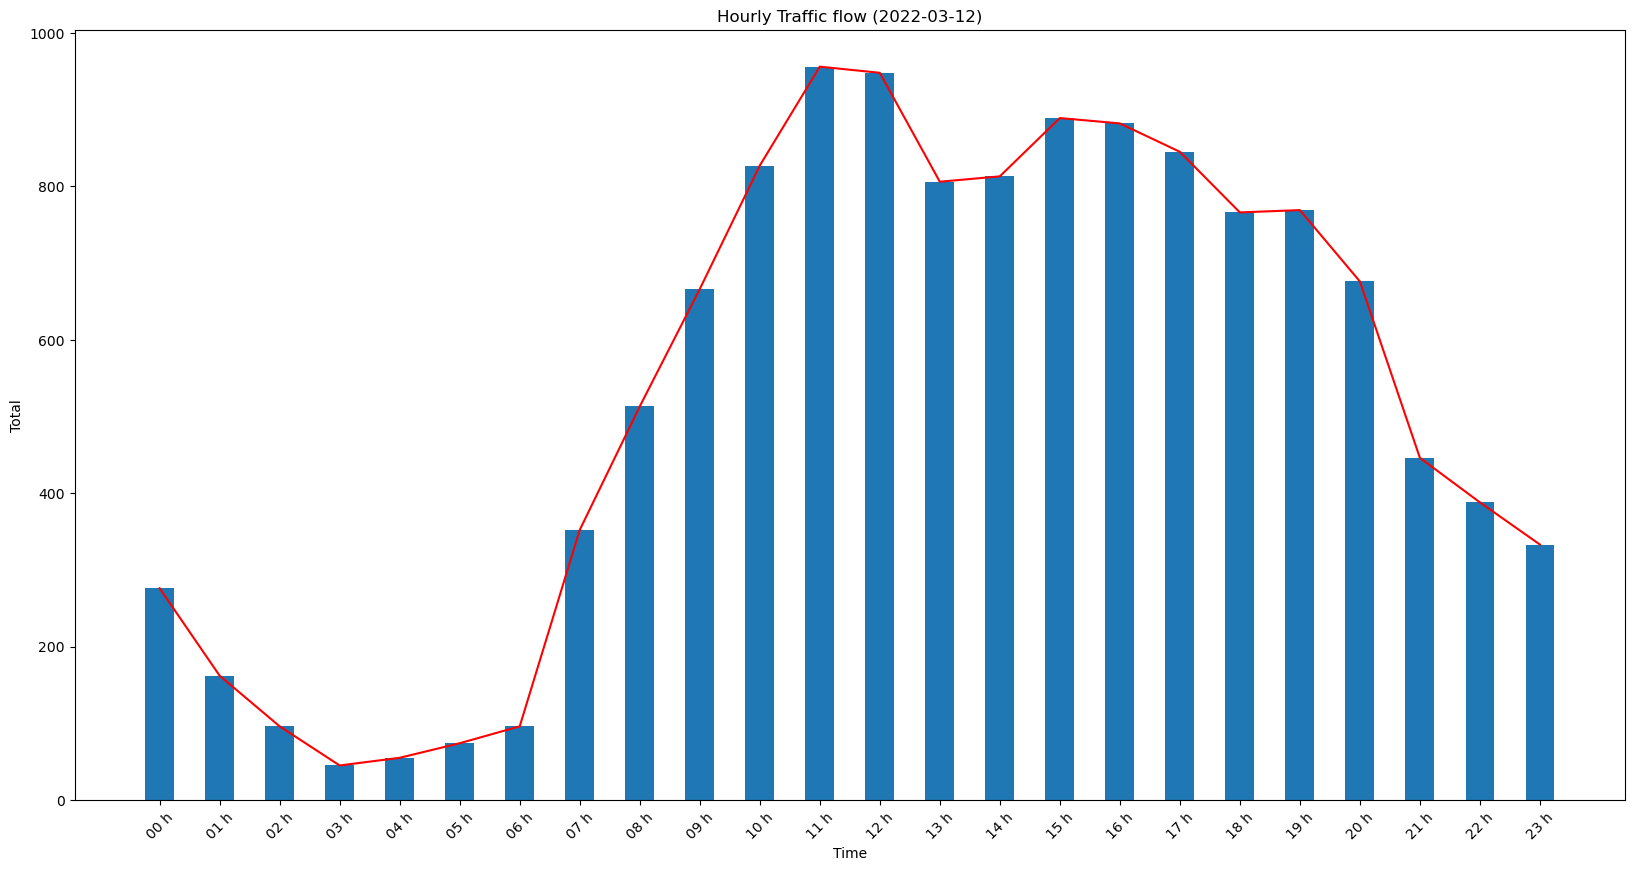

In [138]:
# bar plot of the data
plt.figure(figsize=(20,10))
plt.bar(df4.index, df4['total'], width=0.02)
plt.title('Hourly Traffic flow (2022-03-12)')
# PLOT A polyline   
plt.plot(df4.index, df4['total'], color='red')
plt.xlabel('Time')
# show only the hours
plt.xticks(df4.index, df4.index.strftime("%H h"), rotation=45)
plt.ylabel('Total')
plt.show()


#### Now lets normalize the data

In [129]:
''' # lets normalize the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df['total'] = scaler.fit_transform(df[['total']])
df

df3['total'] = scaler.fit_transform(df3[['total']])
df3

df_weekly['total'] = scaler.fit_transform(df_weekly[['total']])
df_weekly '''



" # lets normalize the data\nfrom sklearn.preprocessing import MinMaxScaler\n\nscaler = MinMaxScaler()\ndf['total'] = scaler.fit_transform(df[['total']])\ndf\n\ndf3['total'] = scaler.fit_transform(df3[['total']])\ndf3\n\ndf_weekly['total'] = scaler.fit_transform(df_weekly[['total']])\ndf_weekly "

### From the above plot we can see that we have some missing values, so we need to fill them
### mice imputer

In [130]:
# for all the values that are zero, we will replace them using mice imputer
from fancyimpute import IterativeImputer

# replace all df['total'] values that are zero with nan
df['total'] = df['total'].replace(0, np.nan)
# calling the  MICE class
mice_imputer = IterativeImputer()

df['total'] = mice_imputer.fit_transform(df[['total']])
df

total
time_index                       
2022-01-12 00:00:00+00:00   161.0
2022-01-12 01:00:00+00:00    77.0
2022-01-12 02:00:00+00:00    43.0
2022-01-12 03:00:00+00:00    31.0
2022-01-12 04:00:00+00:00    23.0
...                           ...
2023-05-25 11:00:00+00:00  1554.0
2023-05-25 12:00:00+00:00  1664.0
2023-05-25 13:00:00+00:00  1492.0
2023-05-25 14:00:00+00:00  1510.0
2023-05-25 15:00:00+00:00   947.0

[11968 rows x 1 columns]

In [131]:
# replace all df['total'] values that are zero with nan
df3['total'] = df3['total'].replace(0, np.nan)
# calling the  MICE class
mice_imputer = IterativeImputer()

df3['total'] = mice_imputer.fit_transform(df3[['total']])
df3

total
time_index                        
2022-01-12 00:00:00+00:00  18096.0
2022-01-13 00:00:00+00:00  13280.0
2022-01-14 00:00:00+00:00  21058.0
2022-01-15 00:00:00+00:00  14540.0
2022-01-16 00:00:00+00:00  13502.0
...                            ...
2023-05-21 00:00:00+00:00  17365.0
2023-05-22 00:00:00+00:00  24303.0
2023-05-23 00:00:00+00:00  24993.0
2023-05-24 00:00:00+00:00  24834.0
2023-05-25 00:00:00+00:00  14874.0

[499 rows x 1 columns]

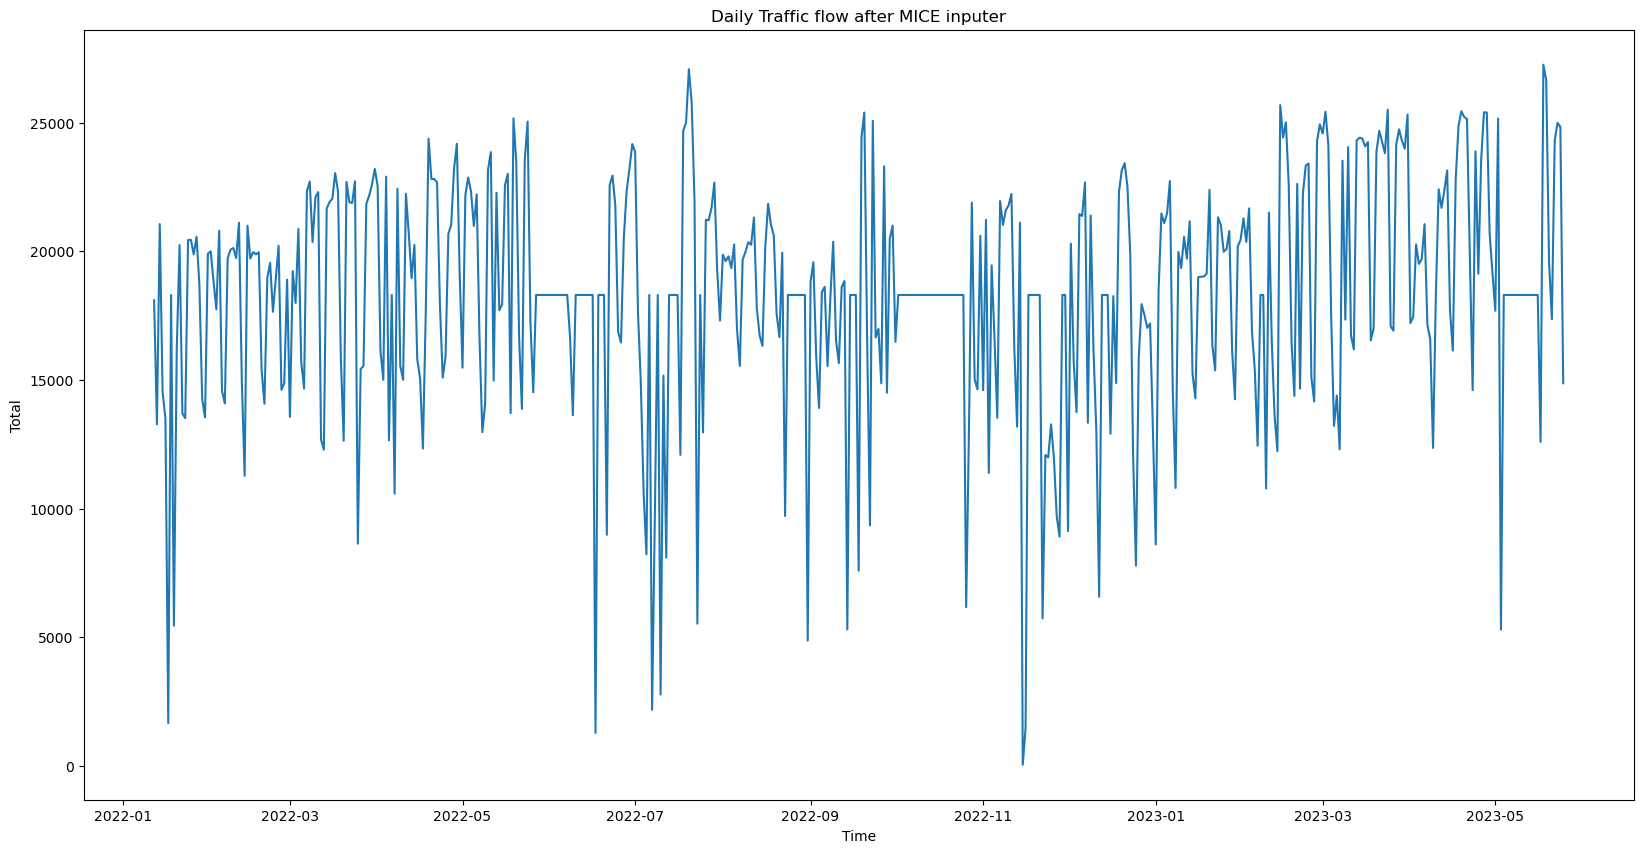

In [132]:
# plot the data after mice input
plt.figure(figsize=(20,10))
plt.plot(df3.index, df3['total'])
plt.title('Daily Traffic flow after MICE inputer')
plt.xlabel('Time')
plt.ylabel('Total')
plt.show()


In [ ]:
# plot the data after mice input
plt.figure(figsize=(20,10))
plt.plot(df.index, df['total'])
plt.title('Daily Traffic flow after MICE inputer')
plt.xlabel('Time')
plt.ylabel('Total')
plt.show()

In [133]:
# take only the data from may to july
may_july = df['2022-05-20':'2022-07-01']
may_july

total
time_index                       
2022-05-20 00:00:00+00:00   118.0
2022-05-20 01:00:00+00:00   105.0
2022-05-20 02:00:00+00:00    62.0
2022-05-20 03:00:00+00:00    42.0
2022-05-20 04:00:00+00:00    84.0
...                           ...
2022-07-01 19:00:00+00:00  1402.0
2022-07-01 20:00:00+00:00  1018.0
2022-07-01 21:00:00+00:00   740.0
2022-07-01 22:00:00+00:00   634.0
2022-07-01 23:00:00+00:00   405.0

[1032 rows x 1 columns]

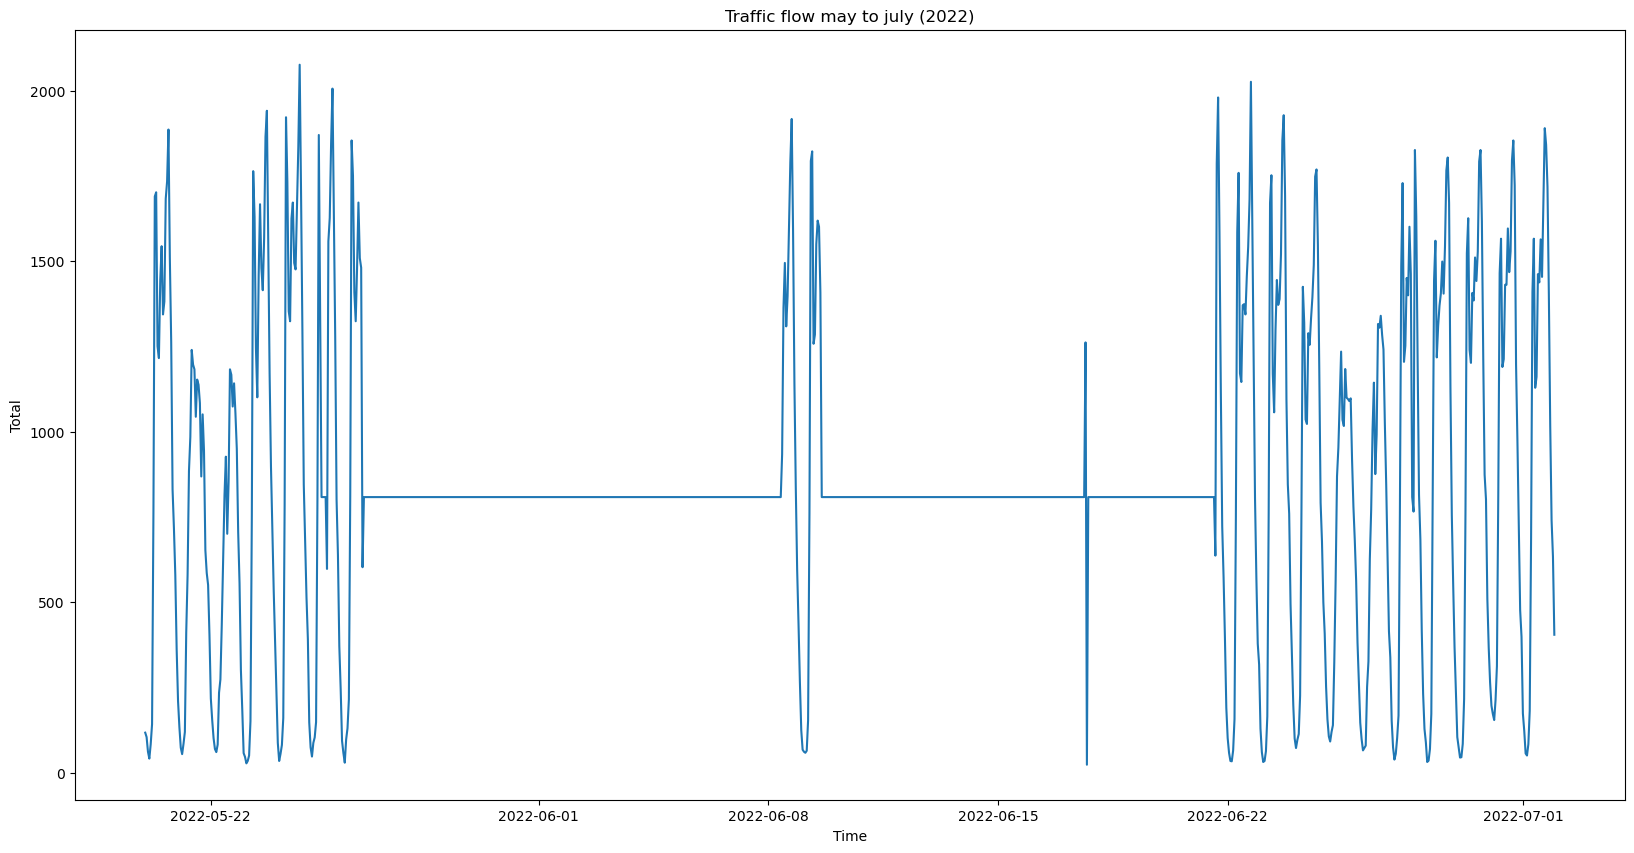

In [134]:
# plot the data
plt.figure(figsize=(20,10))
plt.plot(may_july.index, may_july['total'])
plt.title('Traffic flow may to july (2022)')
plt.xlabel('Time')
plt.ylabel('Total')
plt.show()


In [66]:
vals = df['total'].values
vals.reshape(-1, 1)

array([[ 161.],
       [  77.],
       [  43.],
       ...,
       [1492.],
       [1510.],
       [ 947.]])

In [74]:
# Lets normalize the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df['total'] = scaler.fit_transform(df[['total']])
df


total
time_index                         
2022-01-12 00:00:00+00:00  0.064371
2022-01-12 01:00:00+00:00  0.029930
2022-01-12 02:00:00+00:00  0.015990
2022-01-12 03:00:00+00:00  0.011070
2022-01-12 04:00:00+00:00  0.007790
...                             ...
2023-05-25 11:00:00+00:00  0.635506
2023-05-25 12:00:00+00:00  0.680607
2023-05-25 13:00:00+00:00  0.610086
2023-05-25 14:00:00+00:00  0.617466
2023-05-25 15:00:00+00:00  0.386634

[11968 rows x 1 columns]

### Once the data is ready, we can start building the model

### Create input and output sequences:  
#### how many previous time steps the model will consider to make predictions (like a window)

#### we should probably consider a window of maybe 14 days (2 weeks) to predict the next 24 hours 

In [75]:
sequence_length = 360  # Define the sequence length

input_sequences = []
output_sequences = []
tot_len = len(df)

X_train = []
y_train = []

# Iterate through the DataFrame starting from the sequence length
for i in range(sequence_length, tot_len):
    input_seq = df.iloc[i - sequence_length:i][['total']].values
    output_seq = df.iloc[i]['total']

    input_sequences.append(input_seq)
    output_sequences.append(output_seq)

# Convert the sequences to NumPy arrays
input_sequences = np.array(input_sequences)
output_sequences = np.array(output_sequences)

In [76]:
input_sequences.shape


(11608, 360, 1)

In [77]:
input_sequences.shape

(11608, 360, 1)

### Split the data into training and test sets
#### use 80% of the data for training and 20% for testing

In [78]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(input_sequences, output_sequences, test_size=0.2, random_state=42)

In [79]:
# print the shapes
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(9286, 360, 1)
(2322, 360, 1)
(9286,)
(2322,)


## Now that we have the data ready, we can start building the model


# Model - LSTM (Long Short-Term Memory) - DL

In [80]:
# import the libraries
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

### Create the model

In [81]:
# create the model
model = Sequential()

model.add(LSTM(units=64, return_sequences=True, input_shape=(sequence_length, 1))) 
model.add(LSTM(units=64))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# train the model
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/30
291/291 [==============================] - 83s 277ms/step - loss: 0.0187 - val_loss: 0.0096
Epoch 2/30
291/291 [==============================] - 78s 267ms/step - loss: 0.0093 - val_loss: 0.0069
Epoch 3/30
291/291 [==============================] - 44s 151ms/step - loss: 0.0074 - val_loss: 0.0067
Epoch 4/30
291/291 [==============================] - 43s 149ms/step - loss: 0.0063 - val_loss: 0.0052
Epoch 5/30
291/291 [==============================] - 61s 211ms/step - loss: 0.0052 - val_loss: 0.0039
Epoch 6/30
291/291 [==============================] - 98s 335ms/step - loss: 0.0046 - val_loss: 0.0046
Epoch 7/30
291/291 [==============================] - 98s 338ms/step - loss: 0.0046 - val_loss: 0.0039
Epoch 8/30
291/291 [==============================] - 95s 328ms/step - loss: 0.0043 - val_loss: 0.0034
Epoch 9/30
291/291 [==============================] - 89s 305ms/step - loss: 0.0043 - val_loss: 0.0037
Epoch 10/30
291/291 [==============================] - 57s 196ms/step - l

In [82]:
df

total
time_index                         
2022-01-12 00:00:00+00:00  0.064371
2022-01-12 01:00:00+00:00  0.029930
2022-01-12 02:00:00+00:00  0.015990
2022-01-12 03:00:00+00:00  0.011070
2022-01-12 04:00:00+00:00  0.007790
...                             ...
2023-05-25 11:00:00+00:00  0.635506
2023-05-25 12:00:00+00:00  0.680607
2023-05-25 13:00:00+00:00  0.610086
2023-05-25 14:00:00+00:00  0.617466
2023-05-25 15:00:00+00:00  0.386634

[11968 rows x 1 columns]

In [332]:
# create the model
model = Sequential()

model.add(LSTM(64, return_sequences=True, input_shape=(sequence_length, 1)))
model.add(LSTM(64))
model.add(Dense(1, 'relu'))

model.compile(optimizer='adam', loss='mean_squared_error')


In [333]:
# train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32)

# tf is all that loss

Epoch 1/10
204/204 [==============================] - 33s 153ms/step - loss: 835896.0625
Epoch 2/10
204/204 [==============================] - 30s 146ms/step - loss: 812597.0000
Epoch 3/10
204/204 [==============================] - 31s 151ms/step - loss: 792483.3125
Epoch 4/10
204/204 [==============================] - 52s 257ms/step - loss: 773156.5000
Epoch 5/10
204/204 [==============================] - 28s 137ms/step - loss: 754399.1250
Epoch 6/10
204/204 [==============================] - 27s 134ms/step - loss: 736177.2500
Epoch 7/10
204/204 [==============================] - 27s 134ms/step - loss: 718401.6250
Epoch 8/10
204/204 [==============================] - 28s 137ms/step - loss: 701097.7500
Epoch 9/10
204/204 [==============================] - 28s 138ms/step - loss: 684224.5000
Epoch 10/10
204/204 [==============================] - 29s 142ms/step - loss: 667768.3125


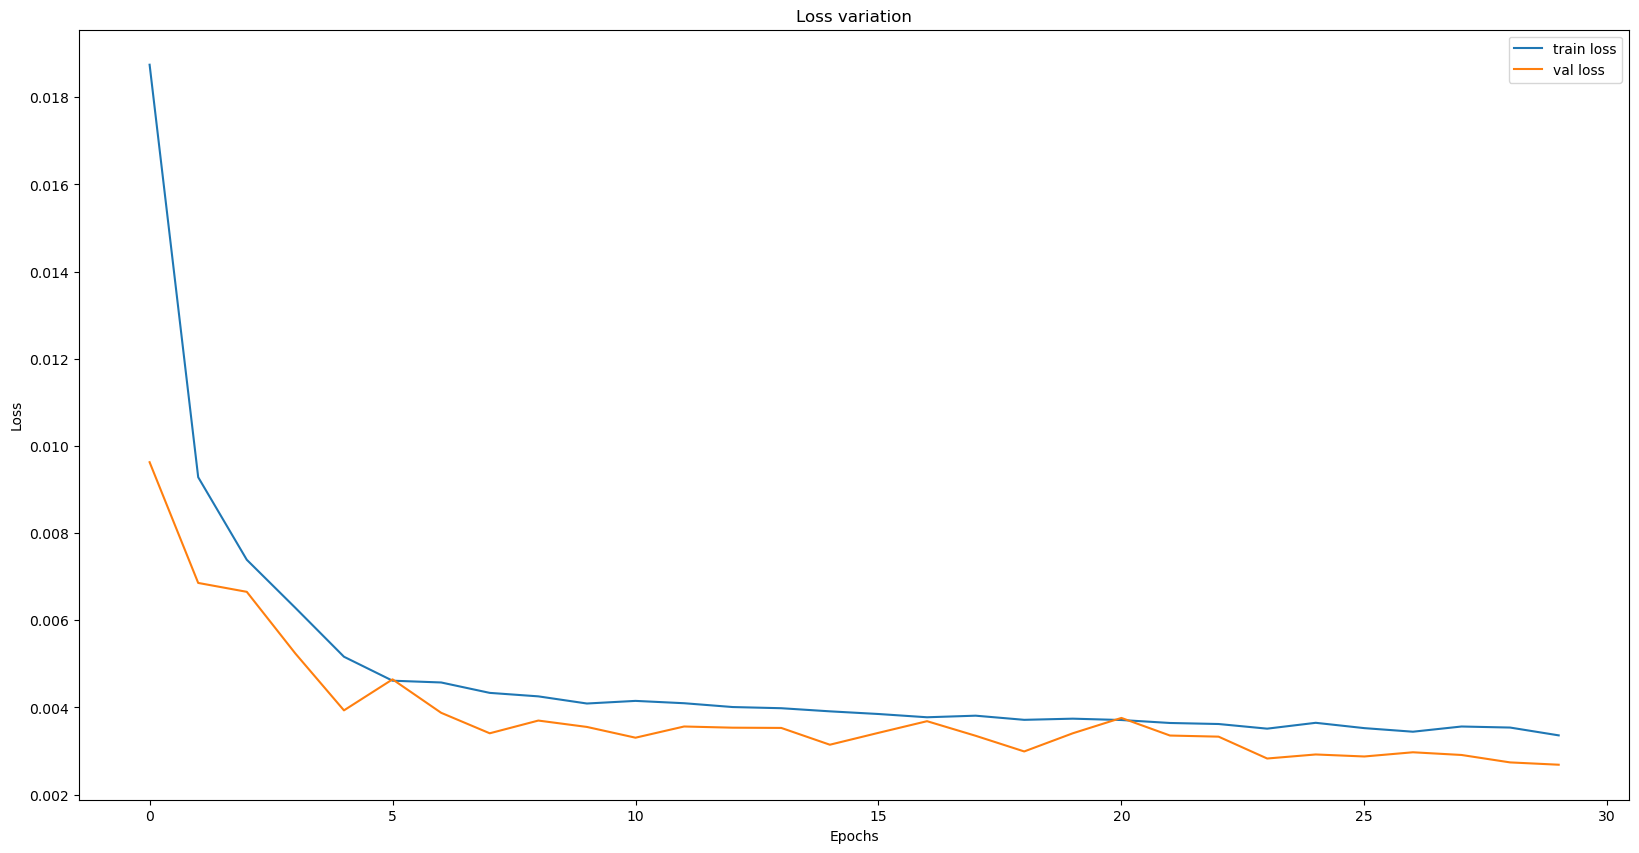

In [83]:
# plot the loss variation 
plt.figure(figsize=(20,10))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss variation')
plt.legend()
plt.show()


### Now lets test the model with the training data

In [84]:
# Evaluate the model on the training data
train_loss = model.evaluate(X_train, y_train)

print('Train Loss: {:.4f}'.format(train_loss))

291/291 [==============================] - 13s 46ms/step - loss: 0.0031
Train Loss: 0.0031


In [85]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
# make predictions on training data
train_predictions = model.predict(X_train)

# Calculate evaluation metrics
mse_train = mean_squared_error(y_train, train_predictions)
mae_train = mean_absolute_error(y_train, train_predictions)

print('Train MSE: {:.4f}'.format(mse_train))
print('Train MAE: {:.4f}'.format(mae_train))


291/291 [==============================] - 13s 45ms/step
Train MSE: 0.0031
Train MAE: 0.0312


291/291 [==============================] - 16s 57ms/step


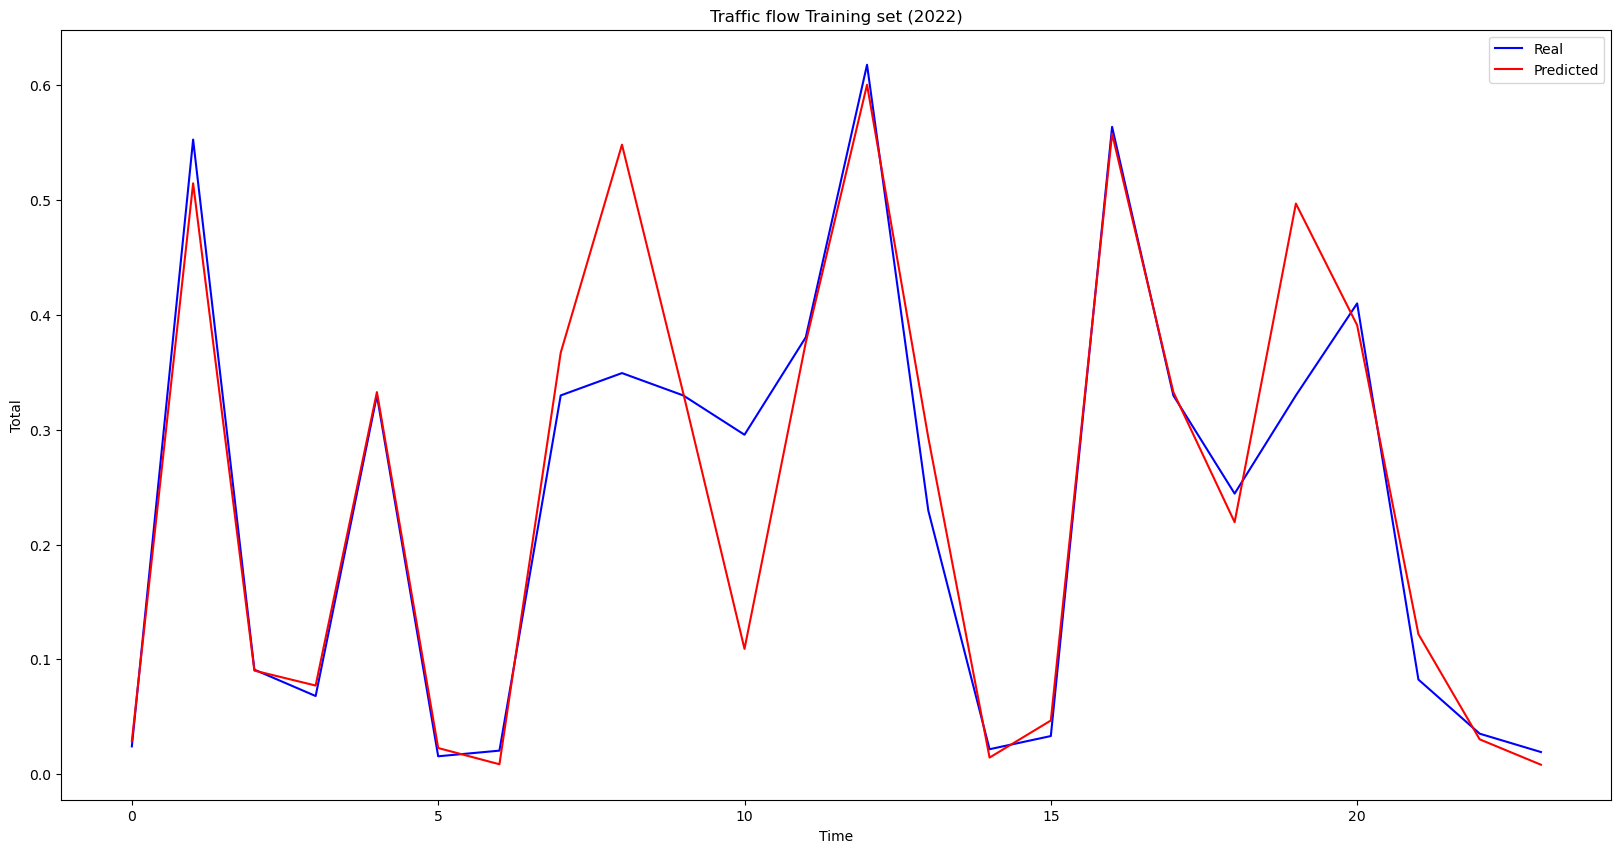

In [86]:
# test the model on the training data
y_pred = model.predict(X_train)

# plot the results
plt.figure(figsize=(20,10))
plt.plot(y_train[:24], color='blue', label='Real')
plt.plot(y_pred[:24], color='red', label='Predicted')
plt.title('Traffic flow Training set (2022)')
plt.xlabel('Time')
plt.ylabel('Total')
plt.legend()
plt.show()

In [87]:
# Evaluate the model on the testing data
loss = model.evaluate(X_test, y_test)

# Make predictions using the model
predictions = model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)

print('Loss: {:.4f}'.format(loss))
print('MSE: {:.4f}'.format(mse))
print('MAE: {:.4f}'.format(mae))

73/73 [==============================] - 7s 98ms/step
Loss: 0.0027
MSE: 0.0027
MAE: 0.0300


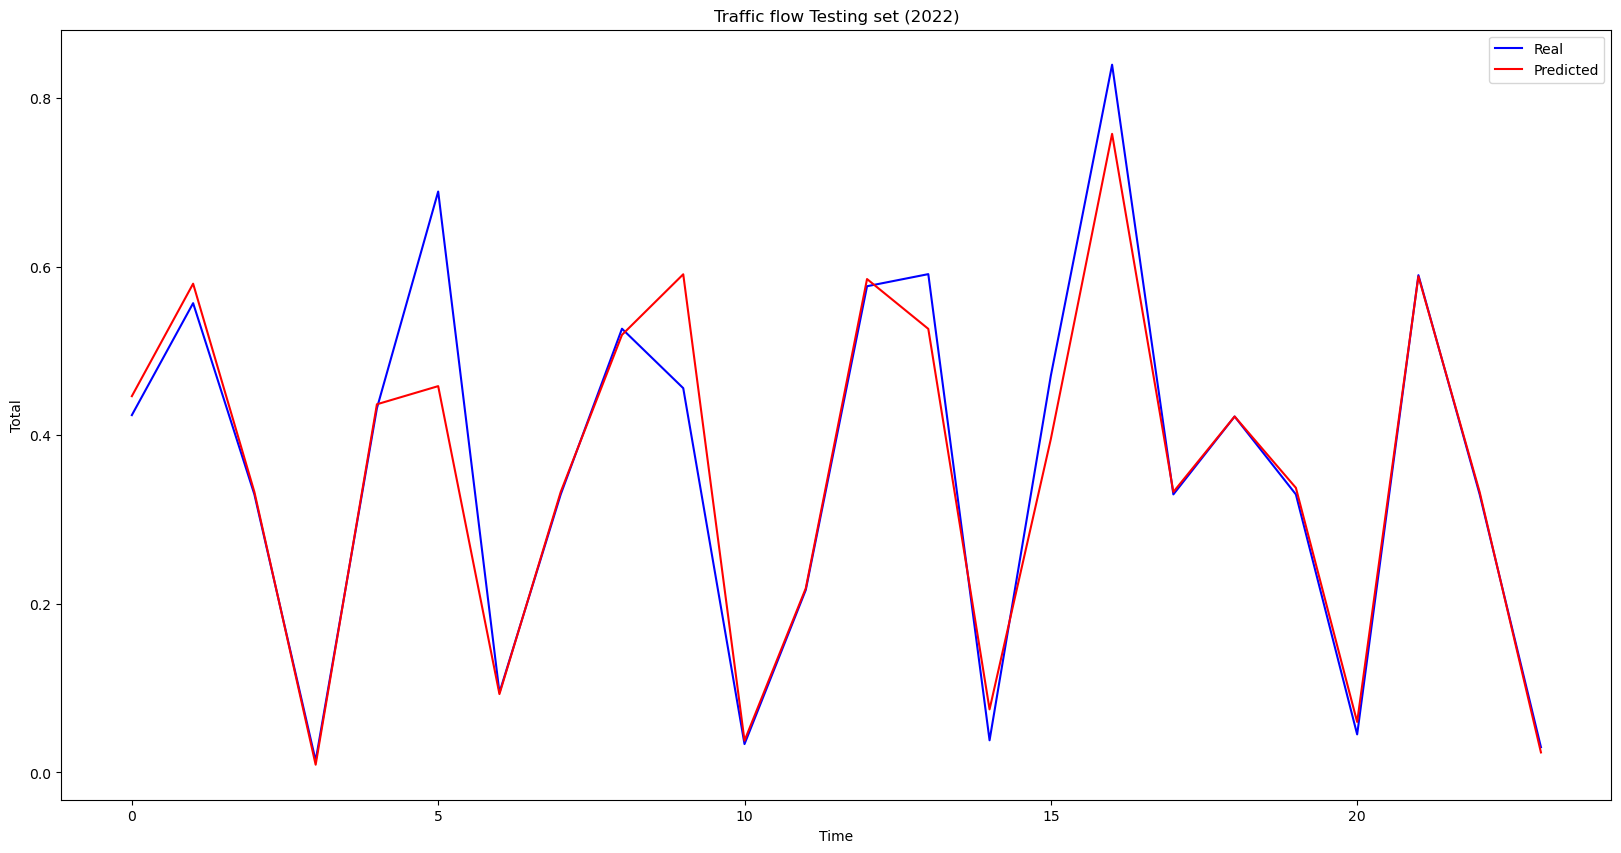

In [88]:
# plot the results 
# 5 * 24 = 120
plt.figure(figsize=(20,10))
plt.plot(y_test[120:144], color='blue', label='Real')
plt.plot(predictions[120:144], color='red', label='Predicted')
plt.title('Traffic flow Testing set (2022)')
plt.xlabel('Time')
plt.ylabel('Total')
plt.legend()
plt.show()

In [89]:
from scalecast.Forecaster import Forecaster

In [90]:
# conver the index to datetime
df.index = pd.to_datetime(df.index)
df

total
time_index                         
2022-01-12 00:00:00+00:00  0.064371
2022-01-12 01:00:00+00:00  0.029930
2022-01-12 02:00:00+00:00  0.015990
2022-01-12 03:00:00+00:00  0.011070
2022-01-12 04:00:00+00:00  0.007790
...                             ...
2023-05-25 11:00:00+00:00  0.635506
2023-05-25 12:00:00+00:00  0.680607
2023-05-25 13:00:00+00:00  0.610086
2023-05-25 14:00:00+00:00  0.617466
2023-05-25 15:00:00+00:00  0.386634

[11968 rows x 1 columns]

In [91]:
f = Forecaster(
    y=df['total'],
    current_dates=df.index,
    frequency='D',
    train_percentage=0.8,
    forecast_horizon=24,
    verbose=1,
    seasonal_period=355,
    model='LSTM',
    model_parameters={'epochs': 15, 'batch_size': 20, 'loss': 'mean_squared_error', 'optimizer': 'adam'},
)

print(f)
# cannot infer freq from a non-convertible dtype on a Series of datetime64[ns, UTC]

Forecaster object with no models evaluated. Data starts at 2022-01-12 00:00:00+00:00, ends at 2023-05-25 15:00:00+00:00, loaded to forecast out 0 periods, has 0 regressors.


### PACF (Partial Auto Correlation Function) plot:
##### measures how much the y variable, in our case, traffic volume, is correlated to past values of itself and how far back a statistically significant correlation exists.

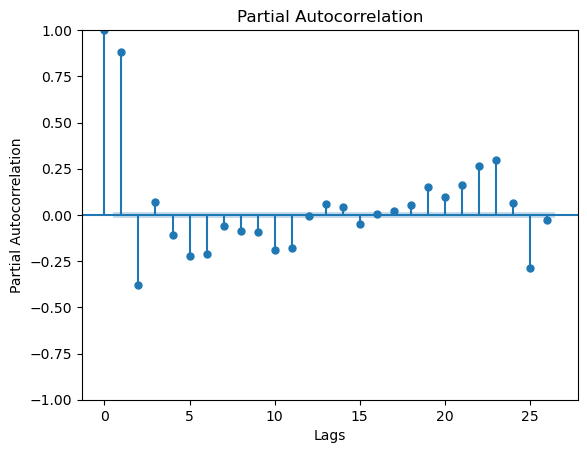

In [92]:
f.plot_pacf(lags=26)
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.show()


## but what exactly do we get from this plot?

In [93]:
df

total
time_index                         
2022-01-12 00:00:00+00:00  0.064371
2022-01-12 01:00:00+00:00  0.029930
2022-01-12 02:00:00+00:00  0.015990
2022-01-12 03:00:00+00:00  0.011070
2022-01-12 04:00:00+00:00  0.007790
...                             ...
2023-05-25 11:00:00+00:00  0.635506
2023-05-25 12:00:00+00:00  0.680607
2023-05-25 13:00:00+00:00  0.610086
2023-05-25 14:00:00+00:00  0.617466
2023-05-25 15:00:00+00:00  0.386634

[11968 rows x 1 columns]

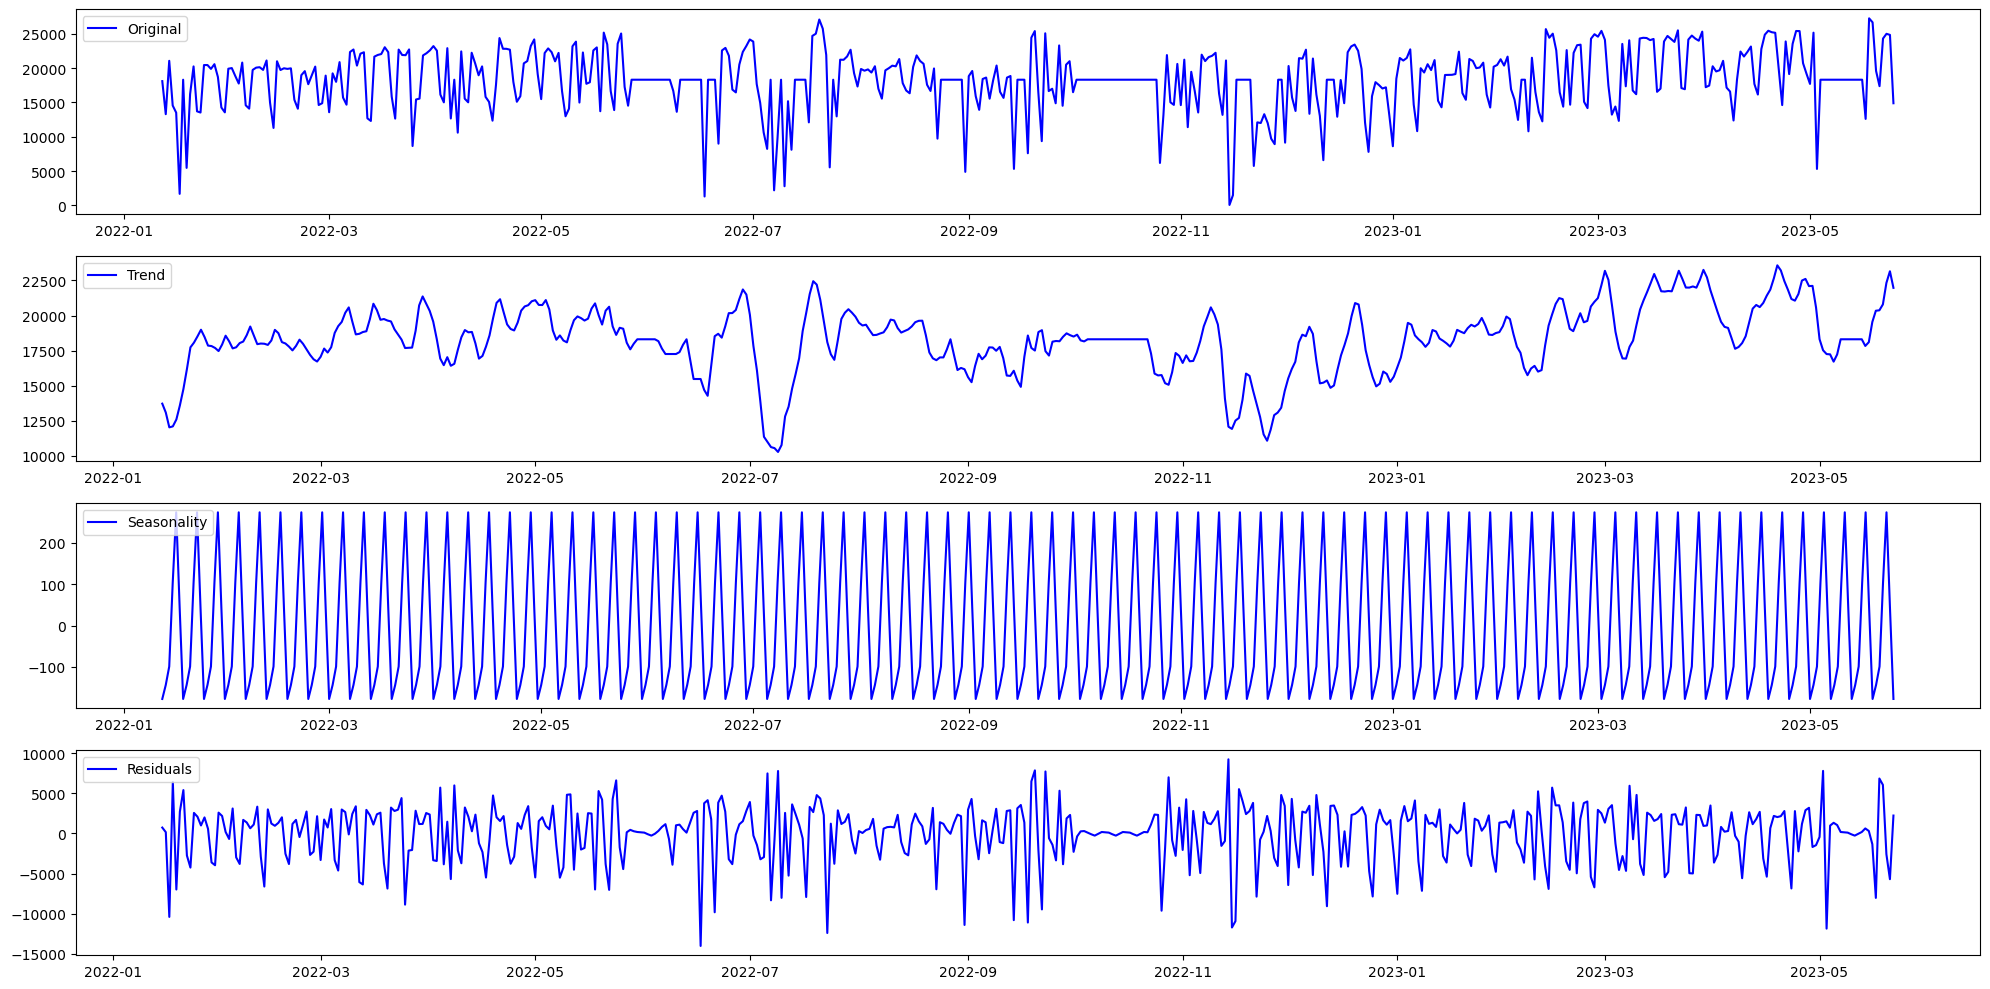

In [94]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series
# note that df3 is the daily data
dec = seasonal_decompose(df3['total'], period=6)
    
    ## df3 is the daily data

# Plot the original data, the trend, the seasonality, and the residuals
plt.figure(figsize=(20,10))
plt.subplot(411)
plt.plot(df3['total'], label='Original', color='blue')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(dec.trend, label='Trend', color='blue')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(dec.seasonal, label='Seasonality', color='blue')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(dec.resid, label='Residuals', color='blue')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()



In [95]:
# instead of daily data, we use the weekly data ??

We can't really see a trend here, but that doesnt mean that there are no patterns in the data.   
There are probably some patterns, most likely cyclical ones, repeating every 12 months maybe ? (ano letivo ~).

In [96]:
# lets test the series for stationarity
stat, pval, _, _, _, _ = f.adf_test(full_res=True)
print('ADF Statistic: {:.4f}'.format(stat))

ADF Statistic: -14.7553


In [97]:
# find the critical value at 5% significance level
from scipy.stats import norm

critical_value = norm.ppf(1 - 0.05)
print('Critical Value: {:.4f}'.format(critical_value))

# check if the ADF statistic is less than the critical value
if stat < critical_value:
    print('Series is Stationary')
else:
    print('Series is Non-Stationary')
    

Critical Value: 1.6449
Series is Stationary


The critical value is derived from statistical tables or computed using statistical software and is based on the desired significance level.  
The significance level represents the threshold below which you would reject the null hypothesis.

In [98]:
df3.index = pd.to_datetime(df3.index)

### Then we can assume that the data is stationary


# ..


In [99]:
df.shape
df

total
time_index                         
2022-01-12 00:00:00+00:00  0.064371
2022-01-12 01:00:00+00:00  0.029930
2022-01-12 02:00:00+00:00  0.015990
2022-01-12 03:00:00+00:00  0.011070
2022-01-12 04:00:00+00:00  0.007790
...                             ...
2023-05-25 11:00:00+00:00  0.635506
2023-05-25 12:00:00+00:00  0.680607
2023-05-25 13:00:00+00:00  0.610086
2023-05-25 14:00:00+00:00  0.617466
2023-05-25 15:00:00+00:00  0.386634

[11968 rows x 1 columns]

In [100]:
series_data = df['total'].values
series_data.shape

(11968,)

In [101]:
# get 3rd of October 2022

# get the index of the date
idx = df.index.get_loc('2022-09-26')
idx



slice(6168, 6192, None)

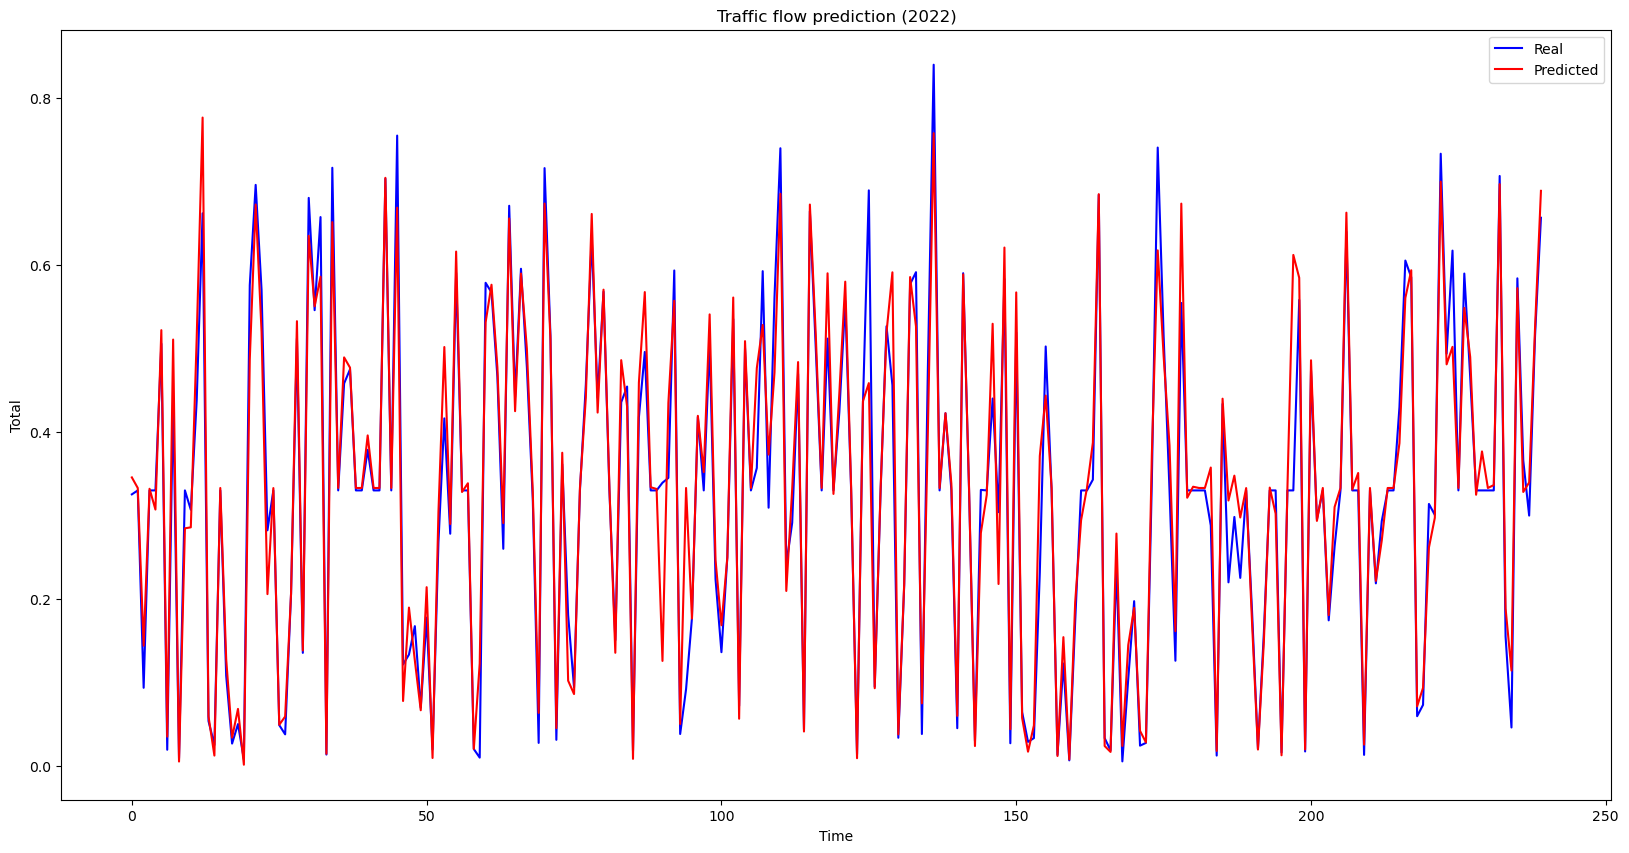

In [102]:
# plot the results 
plt.figure(figsize=(20,10))
plt.plot(y_test[:240], color='blue', label='Real')
plt.plot(predictions[:240], color='red', label='Predicted')
plt.title('Traffic flow prediction (2022)')
plt.xlabel('Time')
plt.ylabel('Total')
plt.legend()
plt.show()

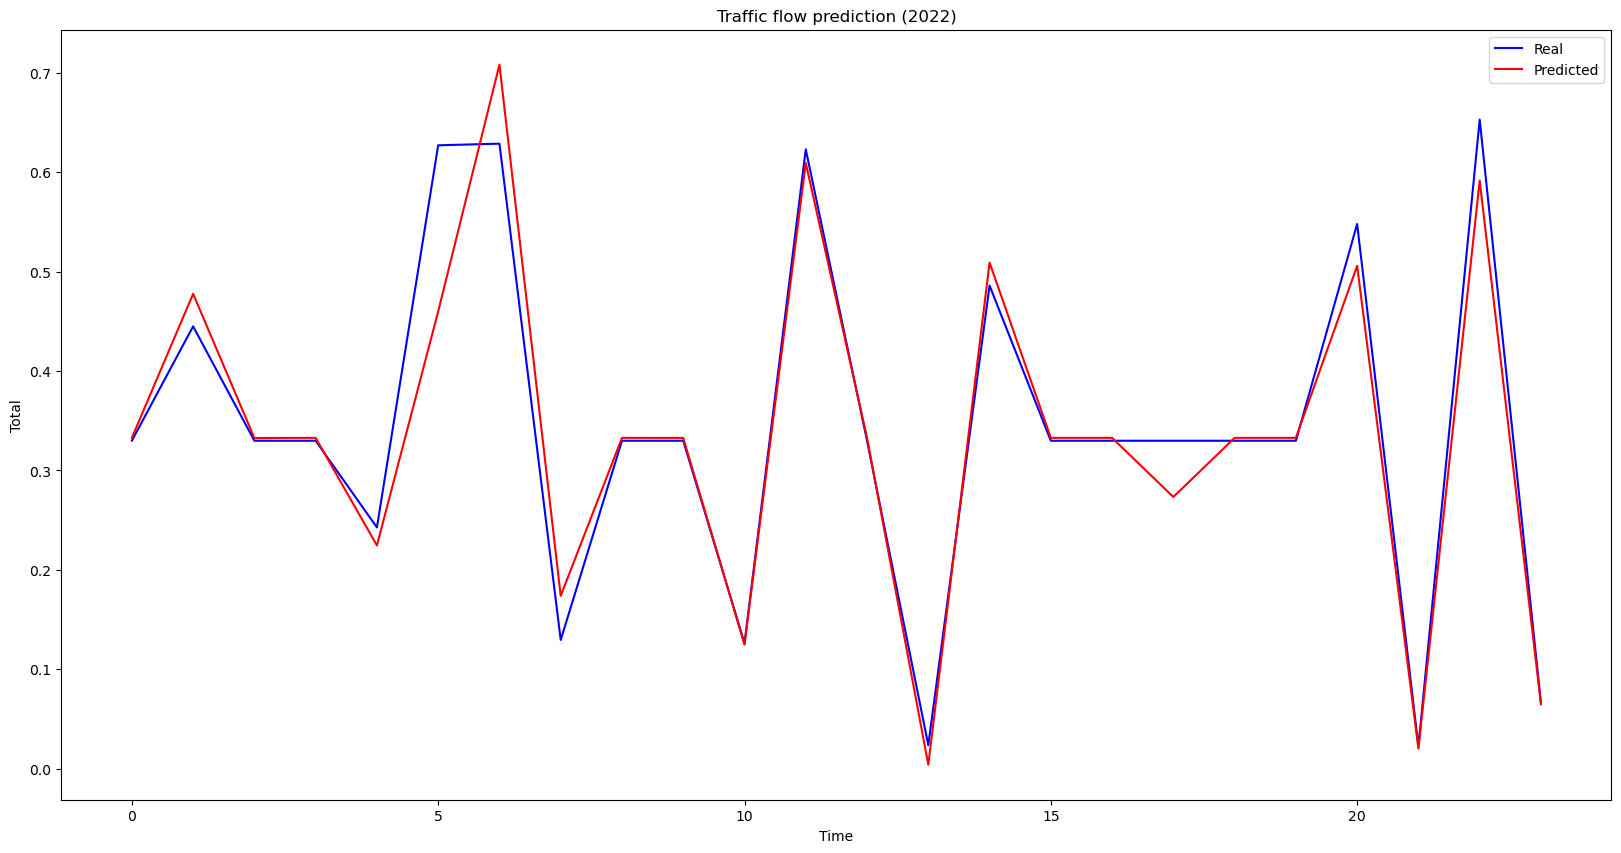

In [103]:
# compare the last 24 hours of the predicted data with the real data (test data)
plt.figure(figsize=(20,10))
plt.plot(y_test[-24:], color='blue', label='Real')
plt.plot(predictions[-24:], color='red', label='Predicted')
plt.title('Traffic flow prediction (2022)')
plt.xlabel('Time')
plt.ylabel('Total')
plt.legend()
plt.show()


In [104]:
series_data

array([0.06437064, 0.0299303 , 0.01599016, ..., 0.6100861 , 0.61746617,
       0.38663387])

In [105]:
series_data.shape  

(11968,)

# Predictions for the next X hours 

In [106]:
# we will use the last 360 entries of the training data as the input to the model
n_steps=360
x_input = series_data[-n_steps:]

# reshape the data
x_input.reshape(1, 360, 1)
temp_input=list(x_input)
lst_output=[]
i=0
while(i < 720):
    
    if(len(temp_input)>n_steps):
        x_input= np.asarray(temp_input[1:]).astype('float32')
        print("{} hour input {}".format(i,x_input))
        #print(x_input)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} hour output {}".format(i,yhat))
        temp_input.append(yhat[0][0])
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.append(yhat[0][0])
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.append(yhat[0][0])
        lst_output.append(yhat[0][0])
        i=i+1
    

print(lst_output)

[0.55120105]
1 hour input [0.32986218 0.32986218 0.32986218 0.32986218 0.32986218 0.32986218
 0.32986218 0.32986218 0.32986218 0.32986218 0.32986218 0.32986218
 0.32986218 0.32986218 0.32986218 0.32986218 0.32986218 0.32986218
 0.32986218 0.32986218 0.32986218 0.32986218 0.32986218 0.32986218
 0.32986218 0.32986218 0.32986218 0.32986218 0.32986218 0.32986218
 0.32986218 0.32986218 0.32986218 0.32986218 0.32986218 0.32986218
 0.32986218 0.32986218 0.32986218 0.32986218 0.32986218 0.32986218
 0.32986218 0.32986218 0.32986218 0.32986218 0.32986218 0.32986218
 0.32986218 0.32986218 0.32986218 0.32986218 0.32986218 0.32986218
 0.32986218 0.32986218 0.32986218 0.32986218 0.32986218 0.32986218
 0.32986218 0.32986218 0.32986218 0.32986218 0.32986218 0.32986218
 0.32986218 0.32986218 0.32986218 0.32986218 0.32986218 0.32986218
 0.32986218 0.32986218 0.32986218 0.32986218 0.32986218 0.32986218
 0.32986218 0.32986218 0.32986218 0.32986218 0.32986218 0.32986218
 0.32986218 0.32986218 0.32986218 0.

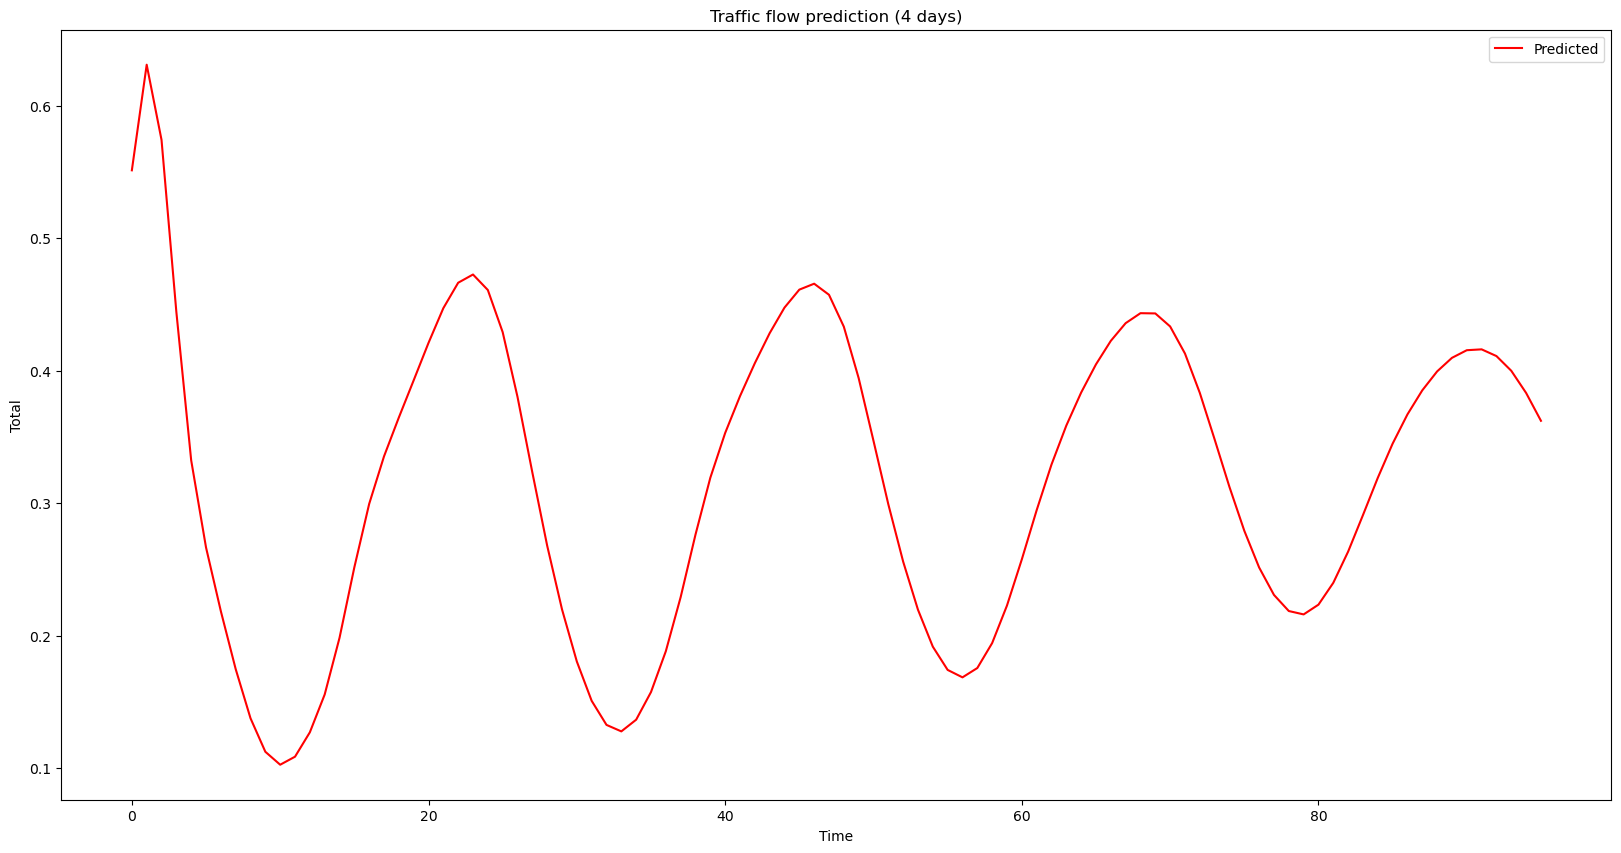

In [107]:
# plot the results
plt.figure(figsize=(20,10))
plt.plot(lst_output[:96], color='red', label='Predicted')
plt.title('Traffic flow prediction (4 days)')
plt.xlabel('Time')
plt.ylabel('Total')
plt.legend()
plt.show()

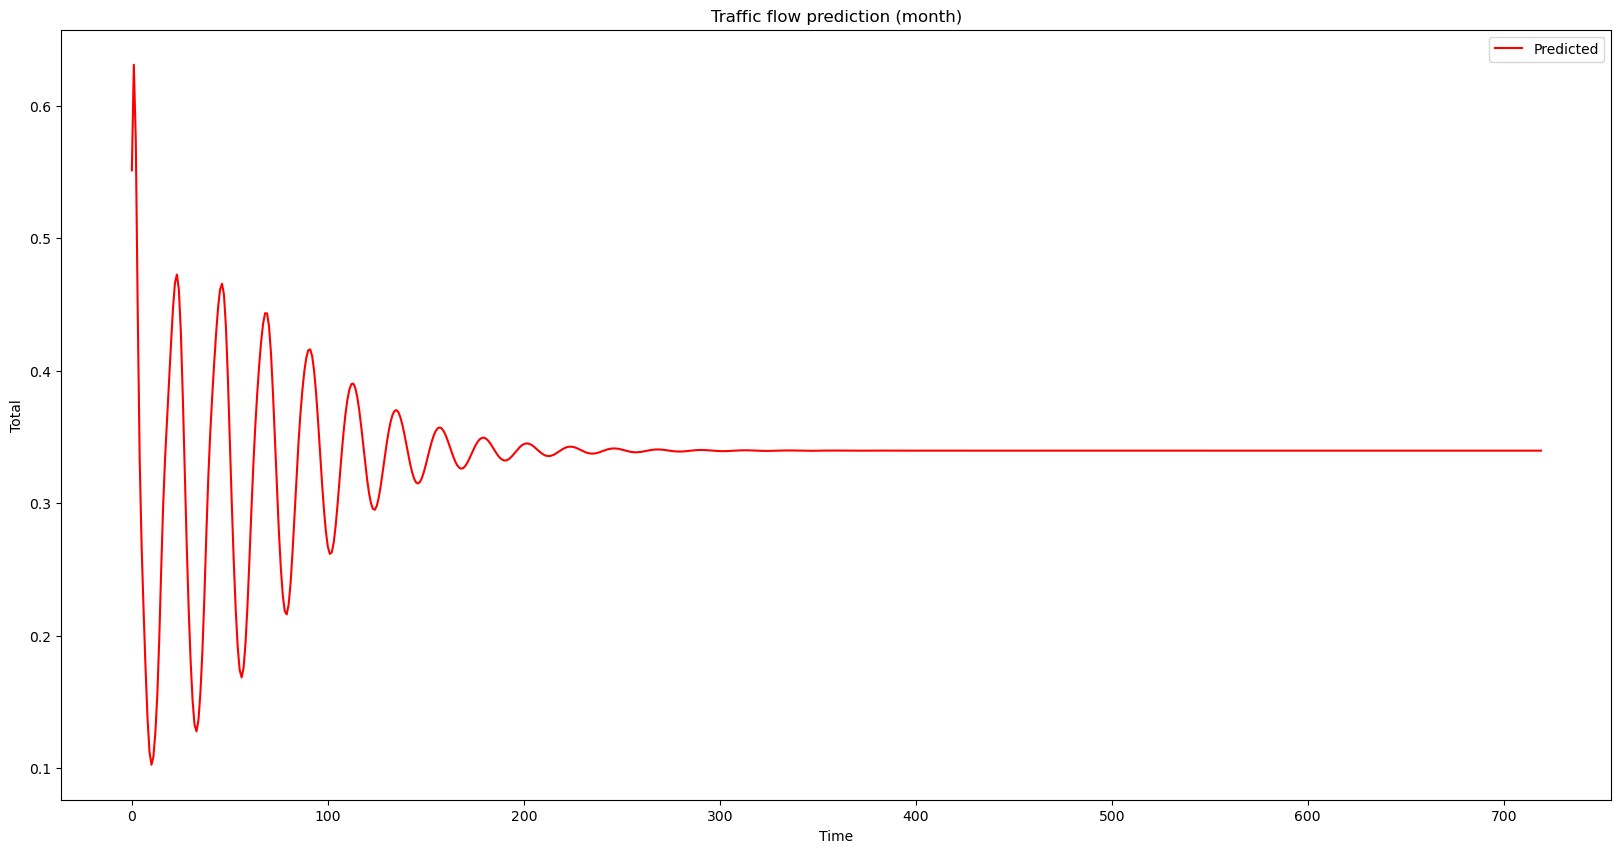

In [108]:
# plot the results
plt.figure(figsize=(20,10))
plt.plot(lst_output, color='red', label='Predicted')
plt.title('Traffic flow prediction (month)')
plt.xlabel('Time')
plt.ylabel('Total')
plt.legend()
plt.show()

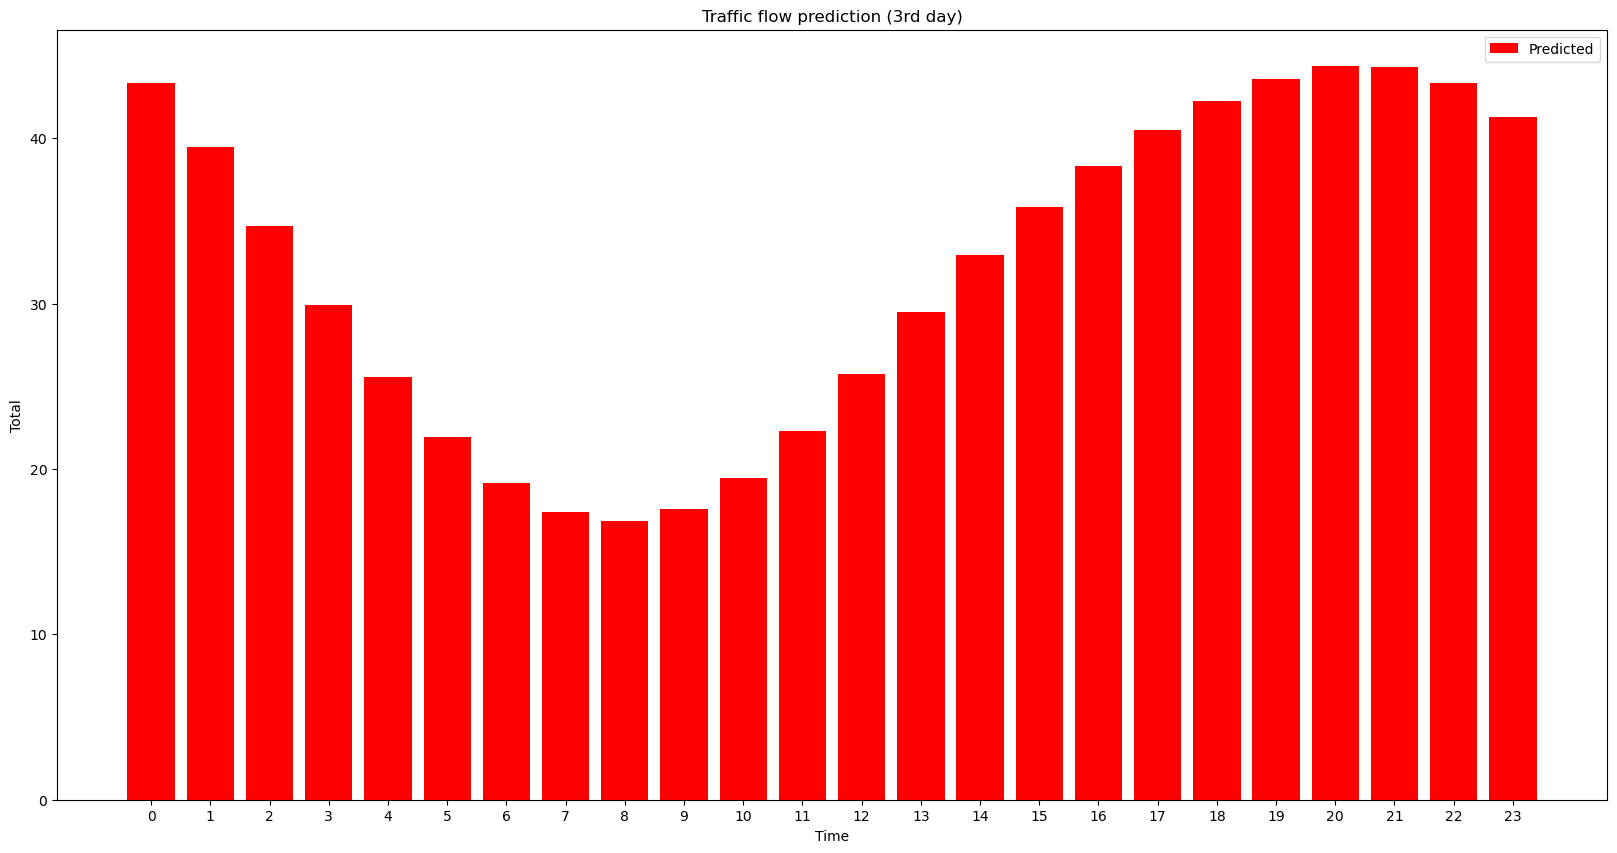

In [109]:
# y values * 100
y_vals = np.array(lst_output) * 100
y_vals
plt.figure(figsize=(20,10))
plt.bar(np.arange(0, 24, 1), y_vals[48:72], color='red', label='Predicted')
plt.title('Traffic flow prediction (3rd day)')
plt.xlabel('Time')
plt.xticks(np.arange(0, 24, 1))
plt.ylabel('Total')
plt.legend()
plt.show()


In [110]:
dar_3 = lst_output[48:72]


dar_3


[0.4332003,
 0.39438996,
 0.3470578,
 0.29914644,
 0.2558684,
 0.21952184,
 0.19166873,
 0.1741148,
 0.16850507,
 0.17553903,
 0.19436306,
 0.22270319,
 0.25752676,
 0.29462647,
 0.32908553,
 0.3585154,
 0.38344014,
 0.4047458,
 0.42247504,
 0.43583286,
 0.4433702,
 0.4431865,
 0.43335325,
 0.4129187]